In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

np.random.seed(0)

# Traditional Dropout Transformer

In [2]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels, out_channels, heads, dropout):
        super(SelfAttention, self).__init__()
        self.heads = heads
        self.query = nn.Linear(in_channels, out_channels)
        self.key = nn.Linear(in_channels, out_channels)
        self.value = nn.Linear(in_channels, out_channels)
        self.fc = nn.Linear(out_channels, out_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dropout(x)
        batch_size, seq_len, in_channels = x.size()

        # Project input to query, key and value
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)

        # Split each query, key, value into self.heads separate pieces
        queries = queries.view(batch_size, seq_len, self.heads, -1)
        keys = keys.view(batch_size, seq_len, self.heads, -1)
        values = values.view(batch_size, seq_len, self.heads, -1)

        # Dot product between queries and keys for each head
        dot = torch.einsum('bqhd,bkhd->bhqk', queries, keys) / (np.sqrt(in_channels))

        # Apply softmax activation
        dot = torch.softmax(dot, dim=-1)
        dot = self.dropout(dot)

        # Weighted sum of values for each head
        out = torch.einsum('bhqk,bkhd->bqhd', dot, values)

        out = out.view(batch_size, seq_len, -1)
        out = self.fc(out)

        return out

class TransformerBlock(nn.Module):
    def __init__(self, in_channels, out_channels, heads, dropout):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(in_channels)
        self.attention = SelfAttention(in_channels, out_channels, heads, dropout)
        self.norm2 = nn.LayerNorm(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Sequential(
            nn.Linear(out_channels, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, in_channels)
        )

    def forward(self, x):
        residual = x
        x = self.norm1(x)
        x = self.attention(x)
        x = self.dropout(x)
        x += residual
        residual = x
        x = self.norm2(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x += residual
        return x

In [3]:
class ViT(nn.Module):
    def __init__(self, img_size, patch_size, num_classes, blocks, heads, dropout=0.05):
        super(ViT, self).__init__()
        num_patches = np.square(img_size // patch_size)

        # Input size is patch dimension
        self.patch_embedding = nn.Linear(np.square(patch_size), heads)
        self.cls_token = nn.Parameter(torch.randn(1, 1, heads))
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches + 1, heads))
        self.dropout = nn.Dropout(dropout)
        self.transformer_blocks = nn.Sequential(*[
            TransformerBlock(heads, heads, heads, dropout) for _ in range(blocks)
        ])
        self.fc = nn.Linear(heads, num_classes)

    def forward(self, x):
        batch_size, _, _, _ = x.size()

        # Reshape into a 4D tensor with dimensions (batch_size, num_patches, 1, patch_dim)
        x = x.view(batch_size, -1, 1, self.patch_embedding.in_features)

        # Transpose the dimensions of the tensor to (batch_size, num_patches, patch_dim, 1)
        # Then flatten so that it is just (batch_size, num_patches, patch_dim)
        x = x.permute(0, 1, 3, 2).flatten(2)
        x = self.patch_embedding(x)
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.position_embedding
        x = self.dropout(x)
        x = self.transformer_blocks(x)
        x = x[:, 0]
        x = self.fc(x)
        return x

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Create the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


model = ViT(img_size=28, patch_size=7, num_classes=10, blocks=6, heads=8).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
torch.manual_seed(0)

conv_losses = []
for epoch in range(20):
    cur_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        conv_losses.append(loss.item())
        cur_loss += loss.item()

    print(f'Epoch {epoch+1} - Loss: {cur_loss / len(train_loader):.3f}')

100%|██████████| 9912422/9912422 [00:00<00:00, 218965894.28it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 107771969.59it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 64055010.71it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5000138.78it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1 - Loss: 1.687
Epoch 2 - Loss: 0.959
Epoch 3 - Loss: 0.725
Epoch 4 - Loss: 0.613
Epoch 5 - Loss: 0.539
Epoch 6 - Loss: 0.490
Epoch 7 - Loss: 0.456
Epoch 8 - Loss: 0.430
Epoch 9 - Loss: 0.412
Epoch 10 - Loss: 0.392
Epoch 11 - Loss: 0.383
Epoch 12 - Loss: 0.370
Epoch 13 - Loss: 0.353
Epoch 14 - Loss: 0.349
Epoch 15 - Loss: 0.339
Epoch 16 - Loss: 0.332
Epoch 17 - Loss: 0.322
Epoch 18 - Loss: 0.315
Epoch 19 - Loss: 0.312
Epoch 20 - Loss: 0.304


In [5]:
with torch.no_grad():
    # Evaluate on the test set
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.3f}')

Test Accuracy: 90.510


# BayesFormer

In [6]:
class BayesSelfAttention(nn.Module):
    def __init__(self, in_channels, out_channels, heads, dropout):
        super(BayesSelfAttention, self).__init__()
        self.heads = heads
        self.query = nn.Linear(in_channels, out_channels)
        self.key = nn.Linear(in_channels, out_channels)
        self.value = nn.Linear(in_channels, out_channels)
        self.fc = nn.Linear(out_channels, out_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_len, in_channels = x.size()

        # Project input to query, key and value
        queries = self.dropout(self.query(x))
        keys = self.dropout(self.key(x))
        values = self.dropout(self.value(x))

        # Split each query, key, value into self.heads separate pieces
        queries = queries.view(batch_size, seq_len, self.heads, -1)
        keys = keys.view(batch_size, seq_len, self.heads, -1)
        values = values.view(batch_size, seq_len, self.heads, -1)

        # Dot product between queries and keys for each head
        dot = torch.einsum('bqhd,bkhd->bhqk', queries, keys) / (np.sqrt(in_channels))

        # Apply softmax activation
        dot = torch.softmax(dot, dim=-1)

        # Weighted sum of values for each head
        out = torch.einsum('bhqk,bkhd->bqhd', dot, values)

        out = out.view(batch_size, seq_len, -1)
        out = self.fc(out)

        return out

class BayesTransformerBlock(nn.Module):
    def __init__(self, in_channels, out_channels, heads, dropout):
        super(BayesTransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(in_channels)
        self.attention = BayesSelfAttention(in_channels, out_channels, heads, dropout)
        self.norm2 = nn.LayerNorm(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Sequential(
            nn.Linear(out_channels, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, in_channels)
        )

    def forward(self, x):
        residual = x
        x = self.norm1(x)
        x = self.attention(x)
        x += residual
        residual = x
        x = self.norm2(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x += residual
        return x

In [7]:
class BayesViT(nn.Module):
    def __init__(self, img_size, patch_size, num_classes, blocks, heads, dropout=0.05):
        super(BayesViT, self).__init__()
        num_patches = np.square(img_size // patch_size)

        # Input size is patch dimension
        self.patch_embedding = nn.Linear(np.square(patch_size), heads)
        self.dropout = nn.Dropout(dropout)
        self.cls_token = nn.Parameter(torch.randn(1, 1, heads))
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches + 1, heads))
        self.transformer_blocks = nn.Sequential(*[
            BayesTransformerBlock(heads, heads, heads, dropout) for _ in range(blocks)
        ])
        self.fc = nn.Linear(heads, num_classes)

    def forward(self, x):
        batch_size, _, _, _ = x.size()

        # Reshape into a 4D tensor with dimensions (batch_size, num_patches, 1, patch_dim)
        x = x.view(batch_size, -1, 1, self.patch_embedding.in_features)

        # Transpose the dimensions of the tensor to (batch_size, num_patches, patch_dim, 1)
        # Then flatten so that it is just (batch_size, num_patches, patch_dim)
        x = self.dropout(x.permute(0, 1, 3, 2).flatten(2))
        x = self.patch_embedding(x)
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.dropout(self.position_embedding)
        x = self.transformer_blocks(x)
        x = x[:, 0]
        x = self.fc(x)
        return x

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Create the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

model = BayesViT(img_size=28, patch_size=7, num_classes=10, blocks=6, heads=8, dropout=0.05).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
torch.manual_seed(0)

bayes_losses = []
for epoch in range(20):
    cur_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        bayes_losses.append(loss.item())
        cur_loss += loss.item()

    print(f'Epoch {epoch+1} - Loss: {cur_loss / len(train_loader):.3f}')

Epoch 1 - Loss: 1.798
Epoch 2 - Loss: 0.853
Epoch 3 - Loss: 0.602
Epoch 4 - Loss: 0.508
Epoch 5 - Loss: 0.447
Epoch 6 - Loss: 0.404
Epoch 7 - Loss: 0.376
Epoch 8 - Loss: 0.350
Epoch 9 - Loss: 0.337
Epoch 10 - Loss: 0.318
Epoch 11 - Loss: 0.307
Epoch 12 - Loss: 0.292
Epoch 13 - Loss: 0.287
Epoch 14 - Loss: 0.281
Epoch 15 - Loss: 0.267
Epoch 16 - Loss: 0.266
Epoch 17 - Loss: 0.258
Epoch 18 - Loss: 0.254
Epoch 19 - Loss: 0.254
Epoch 20 - Loss: 0.248


In [9]:
with torch.no_grad():
    # Evaluate on the test set
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.3f}')

Test Accuracy: 92.390


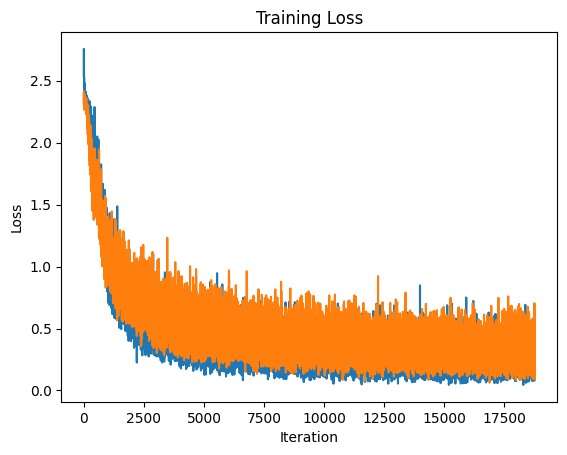

In [13]:
import matplotlib.pyplot as plt

# plot losses
plt.plot(range(len(bayes_losses)), bayes_losses, label='Bayesian Dropout ViT')
plt.plot(range(len(conv_losses)), conv_losses, label='Conventional Dropout ViT')
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [30]:
import torch.nn.functional as F
from torchvision.transforms.functional import rotate

# Rotate the digit '1' by various angles
rotations = [0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180, 195, 210, 225, 240, 255, 270, 285, 300, 315, 330, 345]
one = test_dataset[2][0]
rotated_ones = [rotate(one, angle) for angle in rotations]

# Calculate the predictions and uncertainties for each rotated image
with torch.no_grad():
    model.eval()
    for i, rotated_one in enumerate(rotated_ones):
        rotated_one = rotated_one.unsqueeze(0).to(device)
        outputs = torch.stack([model(rotated_one) for _ in range(50)])
        mean_output = outputs.mean(dim=0)
        prediction = torch.argmax(mean_output)
        predictive_entropy = -torch.sum(mean_output * F.log_softmax(mean_output, dim=-1), dim=-1)
        print(f"Rotation {rotations[i]} - Prediction {prediction} - Entropy {predictive_entropy}")

Rotation 0 - Prediction 1 - Entropy tensor([-179.1366], device='cuda:0')
Rotation 15 - Prediction 1 - Entropy tensor([-149.9943], device='cuda:0')
Rotation 30 - Prediction 1 - Entropy tensor([-140.1392], device='cuda:0')
Rotation 45 - Prediction 1 - Entropy tensor([-150.0211], device='cuda:0')
Rotation 60 - Prediction 3 - Entropy tensor([-175.2552], device='cuda:0')
Rotation 75 - Prediction 7 - Entropy tensor([-149.2538], device='cuda:0')
Rotation 90 - Prediction 7 - Entropy tensor([-229.9515], device='cuda:0')
Rotation 105 - Prediction 7 - Entropy tensor([-248.6514], device='cuda:0')
Rotation 120 - Prediction 2 - Entropy tensor([-170.4012], device='cuda:0')
Rotation 135 - Prediction 5 - Entropy tensor([-76.7025], device='cuda:0')
Rotation 150 - Prediction 3 - Entropy tensor([-89.2458], device='cuda:0')
Rotation 165 - Prediction 1 - Entropy tensor([-68.8396], device='cuda:0')
Rotation 180 - Prediction 1 - Entropy tensor([-85.4281], device='cuda:0')
Rotation 195 - Prediction 1 - Entropy

(12,)
(12,)


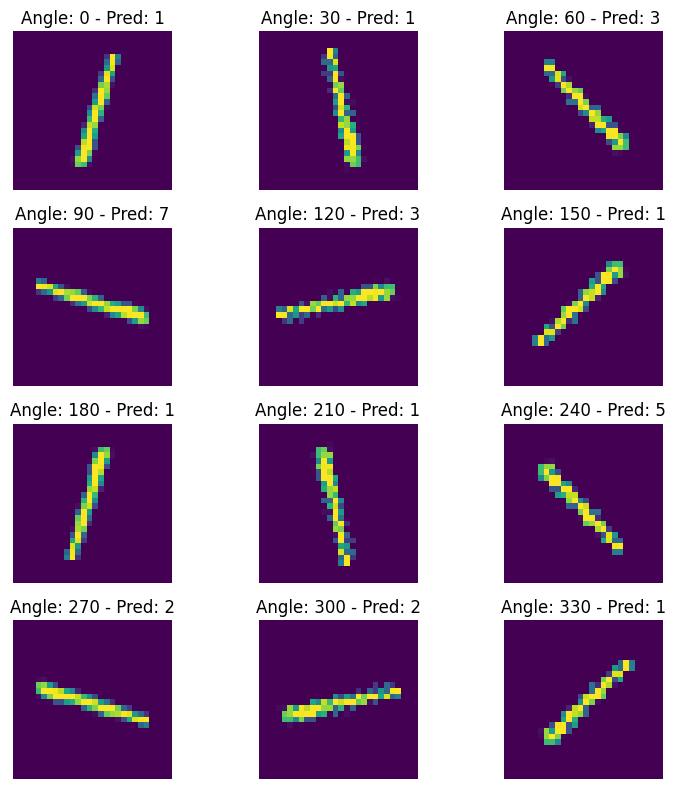

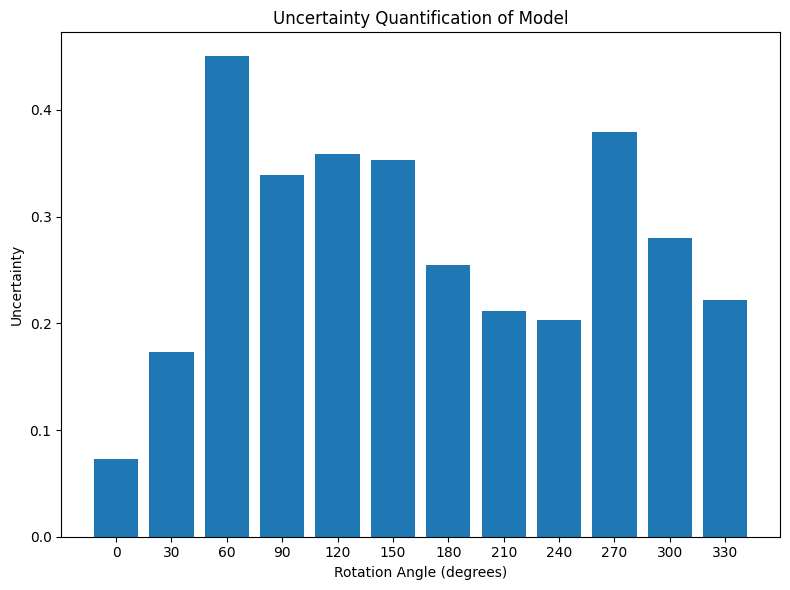

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import functional as F

# Define rotation angles
angles = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]

# Rotate the image at each angle and get the model's predictions
img = test_dataset[2][0]
predictions = [[] for _ in range(len(angles))]
model.train()
with torch.no_grad():
    for i, angle in enumerate(angles):
        rotated_img = F.rotate(img, angle)
        for _ in range(50):
            outputs = model(rotated_img.unsqueeze(0).to(device))
            probabilities = torch.nn.functional.softmax(outputs, dim=-1).cpu().numpy().squeeze()
            predictions[i].append(probabilities)

# Compute the mean and variance of the predictions for each class
predictions = np.array(predictions)
mean_predictions = np.argmax(np.mean(predictions, axis=1), axis=1)
variance_predictions = np.sum(np.var(predictions, axis=1), axis=1)

print(mean_predictions.shape)
print(variance_predictions.shape)

# Rotate the image at each angle and plot
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(8, 8))
axes = axes.flatten()
img = test_dataset[2][0]
for i, angle in enumerate(angles):
    rotated_img = F.rotate(img, angle)
    axes[i].imshow(np.transpose(rotated_img.numpy(), (1, 2, 0)))
    axes[i].set_title(f"Angle: {angle} - Pred: {mean_predictions[i]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Plot the mean predictions and uncertainty
# fig, ax = plt.subplots(figsize=(8, 6))
# ax.bar(np.arange(len(angles)), mean_predictions, capsize=5)
# ax.set_xticks(np.arange(len(angles)))
# ax.set_xticklabels(angles)
# ax.set_xlabel('Rotation Angle (degrees)')
# ax.set_ylabel('Class')
# ax.set_title('Prediction of Rotated Image')
# plt.tight_layout()
# plt.show()

# Plot the mean predictions and uncertainty
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(np.arange(len(angles)), np.sqrt(variance_predictions), capsize=5)
ax.set_xticks(np.arange(len(angles)))
ax.set_xticklabels(angles)
ax.set_xlabel('Rotation Angle (degrees)')
ax.set_ylabel('Uncertainty')
ax.set_title('Uncertainty Quantification of Model')
plt.tight_layout()
plt.show()


